<a href="https://colab.research.google.com/github/saritmaitra/DJIA-prediction/blob/main/unseen_data_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python_wtd
from python_wtd import WTD
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
import warnings
import seaborn as sns
sns.set()
import pandas_datareader as web
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

In [ ]:
df = web.DataReader('^DJI', data_source = 'yahoo', start = '2000-01-01')
print(df.head())
print('\n')
print(df.shape)

                    High           Low          Open         Close     Volume     Adj Close
Date                                                                                       
2000-01-03  11522.009766  11305.690430  11501.849609  11357.509766  169750000  11357.509766
2000-01-04  11350.059570  10986.450195  11349.750000  10997.929688  178420000  10997.929688
2000-01-05  11215.099609  10938.669922  10989.370117  11122.650391  203190000  11122.650391
2000-01-06  11313.450195  11098.450195  11113.370117  11253.259766  176550000  11253.259766
2000-01-07  11528.139648  11239.919922  11247.059570  11522.559570  184900000  11522.559570


(5288, 6)


In [ ]:
dataset = df.copy()
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=dataset.index,
                open=dataset['Open'],
                high=dataset['High'],
                low=dataset['Low'],
                close=dataset['Close'])])
fig.show()
print('\n')


In [ ]:
dataset.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [ ]:
# empirical quantile of daily returns
import scipy.stats
dataset['daily_return'] = dataset['Adj Close'].pct_change()
round(dataset["daily_return"],2).quantile(0.05)

-0.02

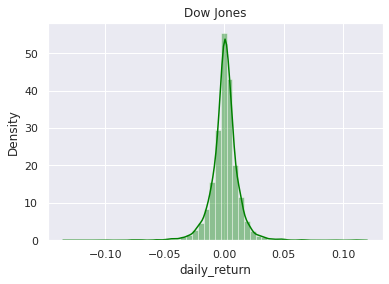

In [ ]:
import seaborn as sns
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(dataset['daily_return'], color="green")
plt.title('Dow Jones')
plt.grid(True)
plt.show()

The 0.05 (p=0.05) empirical quantile of daily returns is at -0.02. This means that with 95% confidence, the worst daily loss will not exceed 2% (of the investment).

***As an example, if we have a €1M investment, our one-day 5% VaR is 0.02 * €1M = € 2k***

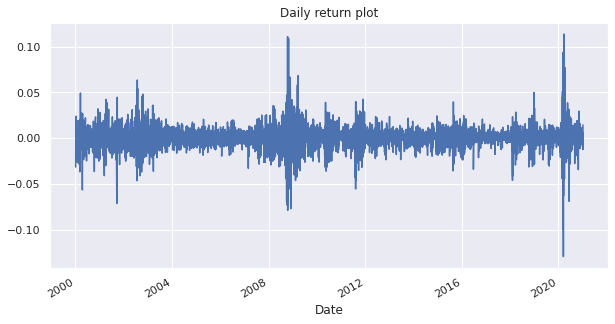

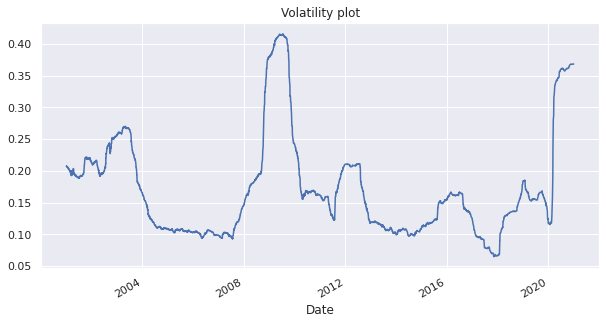

In [ ]:
dataset['daily_return'].plot(figsize = (10,5), grid=True)
plt.title('Daily return plot')
plt.show()

dataset['volatility'] = dataset['daily_return'].rolling(252).std()*(252**0.5)
dataset['volatility'].plot(figsize = (10,5), grid=True)
plt.title('Volatility plot')
plt.show()

In [ ]:
# resetting index 
dataset.reset_index(inplace = True) 
dataset.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,daily_return,volatility
5282,2020-12-30,30525.349609,30393.039062,30415.089844,30409.560547,291890000,30409.560547,0.002436,0.368265
5283,2020-12-31,30637.470703,30344.500000,30417.640625,30606.480469,284470000,30606.480469,0.006476,0.368147
5284,2021-01-04,30674.279297,29881.820312,30627.470703,30223.890625,475080000,30223.890625,-0.012500,0.368276
5285,2021-01-05,30504.890625,30141.779297,30204.250000,30391.599609,350910000,30391.599609,0.005549,0.368306
5286,2021-01-06,31022.650391,30313.070312,30362.779297,30829.400391,500430000,30829.400391,0.014405,0.368538


In [ ]:
dataset = dataset.sort_values(by = 'Date', ascending=True)
dataset.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,daily_return,volatility
5282,2020-12-30,30525.349609,30393.039062,30415.089844,30409.560547,291890000,30409.560547,0.002436,0.368265
5283,2020-12-31,30637.470703,30344.500000,30417.640625,30606.480469,284470000,30606.480469,0.006476,0.368147
5284,2021-01-04,30674.279297,29881.820312,30627.470703,30223.890625,475080000,30223.890625,-0.012500,0.368276
5285,2021-01-05,30504.890625,30141.779297,30204.250000,30391.599609,350910000,30391.599609,0.005549,0.368306
5286,2021-01-06,31022.650391,30313.070312,30362.779297,30829.400391,500430000,30829.400391,0.014405,0.368538


In [ ]:
print(dataset.loc[[(len(dataset) -252)]]) # closing price 252 days back

           Date          High           Low          Open         Close     Volume     Adj Close  daily_return  volatility
5035 2020-01-08  28866.179688  28522.509766  28556.140625  28745.089844  291750000  28745.089844      0.005647    0.117112


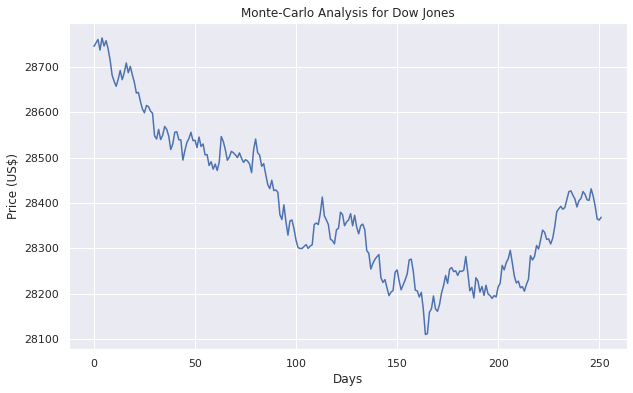

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)
days = 252
start_price = 28745.089844 # Taken from above

#delta t
dt = 1/252
mu = dataset['daily_return'].mean() # mean return
sigma = dataset['daily_return'].std()  # volatility

#Function takes in stock price, number of days to run, mean and standard deviation values
def stock_monte_carlo(start_price, days, mu, sigma):
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        #Shock and drift formulas taken from the Monte Carlo formula
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        drift[x] = mu * dt
        
        #New price = Old price + Old price*(shock+drift)
        price[x] = price[x-1] + (price[x-1] * (drift[x]+shock[x]))
    return price
    
plt.plot(stock_monte_carlo(start_price, days, mu, sigma))
plt.xlabel('Days')
plt.ylabel('Price (US$)')
plt.title('Monte-Carlo Analysis for Dow Jones')
plt.show()

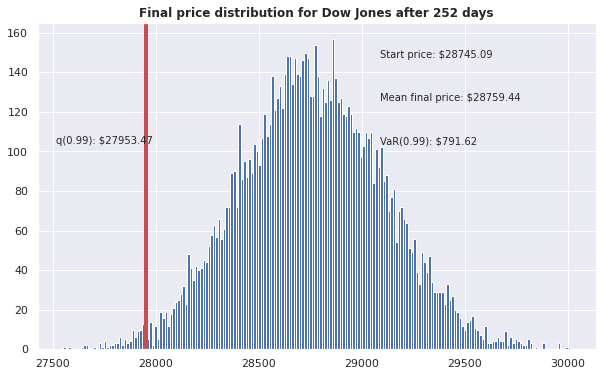

In [ ]:
runs = 10000
simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

plt.hist(simulations, bins = 200)

plt.figtext(0.6,0.8,s="Start price: $%.2f" %start_price)
plt.figtext(0.6,0.7,"Mean final price: $%.2f" % simulations.mean())
plt.figtext(0.6,0.6,"VaR(0.99): $%.2f" % (start_price -q,))
plt.figtext(0.15,0.6, "q(0.99): $%.2f" % q)
plt.axvline(x=q, linewidth=4, color='r')

plt.title(u"Final price distribution for Dow Jones after %s days" %days, weight='bold')
plt.show()

## Setting index

In [ ]:
#dataset.set_index('Date', inplace=True)
dq = df.copy()
dq['h_o'] = dq['High'] - dq['Open'] # distance between Highest and Opening price
dq['l_o'] = dq['Low'] - dq['Open']
dq['Open-Close'] = dq.Open - dq.Close
dq['High-Low'] = dq.High - dq.Low 
dq['volume_gap'] = dq.Volume.pct_change()
# feature engineering
dq['day_of_week'] = dq.index.dayofweek
dq['day_of_month'] = dq.index.day

ema_12 = dq['Adj Close'].ewm(span=10).mean()
ema_26 = dq['Adj Close'].ewm(span=26).mean()
dq['ROC'] = ((dq['Adj Close'] - dq['Adj Close'].shift(5)) / (dq['Adj Close'].shift(5)))*100

delta = dq['Adj Close'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
dq['rsi'] = 100-100/(1+RS_up/RS_down)
dq['macd'] = ema_12 - ema_26
#print(dataset)

lags = 3
# Create the shifted lag series of prior trading period close values
for i in range(0, lags):
    dq["Lag%s" % str(i+1)] = dq["Adj Close"].shift(i+1).pct_change()

future_pred = int(15)
dq['prediction'] = dq['Adj Close'].shift(-future_pred)
dq.head()

,High,Low,Open,Close,Volume,Adj Close,h_o,l_o,Open-Close,High-Low,volume_gap,day_of_week,day_of_month,ROC,rsi,macd,Lag1,Lag2,Lag3,prediction
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03,11522.009766,11305.690430,11501.849609,11357.509766,169750000,11357.509766,20.160156,-196.159180,144.339844,216.319336,NaN,0,3,NaN,NaN,0.000000,NaN,NaN,NaN,11029.889648
2000-01-04,11350.059570,10986.450195,11349.750000,10997.929688,178420000,10997.929688,0.309570,-363.299805,351.820312,363.609375,0.051075,1,4,NaN,NaN,-11.064002,NaN,NaN,NaN,11032.990234
2000-01-05,11215.099609,10938.669922,10989.370117,11122.650391,203190000,11122.650391,225.729492,-50.700195,-133.280273,276.429688,0.138830,2,5,NaN,NaN,-8.672685,-0.031660,NaN,NaN,11028.019531
2000-01-06,11313.450195,11098.450195,11113.370117,11253.259766,176550000,11253.259766,200.080078,-14.919922,-139.889648,215.000000,-0.131109,3,6,NaN,NaN,-0.837661,0.011340,-0.03166,NaN,10738.870117
2000-01-07,11528.139648,11239.919922,11247.059570,11522.559570,184900000,11522.559570,281.080078,-7.139648,-275.500000,288.219727,0.047295,4,7,NaN,NaN,18.224634,0.011743,0.01134,-0.03166,10940.530273


<Figure size 1080x432 with 0 Axes>

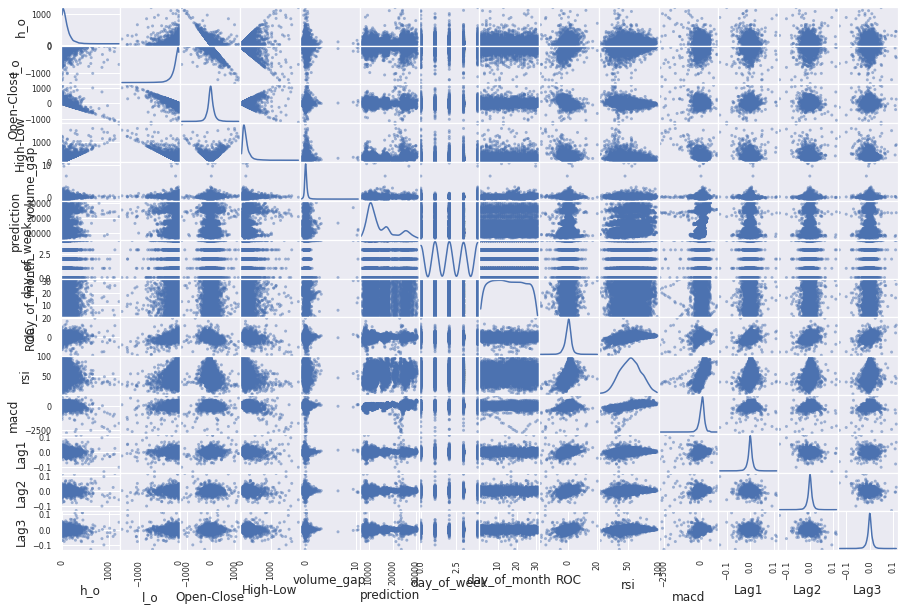

In [ ]:
dq = dq.drop(['High','Low','Open','Close','Volume',	'Adj Close'],1)

plt.figure(figsize= (15,6))
pd.plotting.scatter_matrix(dq, grid=True, diagonal='kde', figsize= (15,10))
plt.show()

In [ ]:
dq = dq.drop(['High','Low','Open','Close','Volume',	'Adj Close'],1)

In [ ]:
dq.dropna(inplace=True)
X = dq.drop(['prediction'],1)
X_fcast = X[-future_pred:] # future prediction set
X = X[:-future_pred] # removing last 15 rows
y = y[:-future_pred]
#y = dq.prediction

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_train, ols.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_train, ols.predict(X_train)))
# The mean squared error
print("Mean squared error: %.2f"
% mean_squared_error(y_test, ols.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, ols.predict(X_test)))

Mean squared error: 25395005.55
Variance score: 0.24
Mean squared error: 25157597.90
Variance score: 0.23


In [ ]:
print('Training Variance score (R^2)', r2_score(y_train, ols.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Test Variance score (R^2): ', r2_score(y_test, ols.predict(X_test)))

Training Variance score (R^2) 0.23788335169817953
Test Variance score (R^2):  0.22862820875255985


In [ ]:
reg = XGBRegressor(objective ='reg:squarederror', n_jobs=-1).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_train, reg.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, reg.predict(X_test)))

Variance score: 0.56
Variance score: 0.47


In [ ]:
prediction = reg.predict(X_fcast)
print('\033[4mExpected Close price for next 15 days\033[0m')
print(prediction)
print('\n')

rmse = np.sqrt(mean_squared_error(y_test[:future_pred], prediction[:future_pred]))
print('Test RMSE: %.3f' % rmse)

Expected Close price for next 15 days
[24754.184 27600.414 24645.855 25840.373 25377.803 29219.156 29659.37
 26990.732 27710.    27163.414 27743.066 26941.684 26479.3   27216.568
 30789.85 ]


Test RMSE: 13583.481


In [ ]:
df.tail(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-05,30504.890625,30141.779297,30204.250000,30391.599609,350910000,30391.599609
2021-01-06,31022.650391,30313.070312,30362.779297,30829.400391,500430000,30829.400391


In [ ]:
d = df[['Adj Close']].tail(len(prediction)); 
d

In [ ]:
d = df[['Adj Close']].tail(len(prediction)); 
d.reset_index(inplace = True)
d = d.append(pd.DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], 
                                             periods = (len(d)+1), freq = 'D', closed = 'right')}))
d = d.tail(future_pred); 
d.set_index('Date', inplace = True)
prediction = pd.DataFrame(prediction)
prediction.index = d.index
prediction.rename(columns = {0: 'Forecasted_price'}, inplace=True)
prediction


,Forecasted_price
Date,
2021-01-07,24754.183594
2021-01-08,27600.414062
2021-01-09,24645.855469
2021-01-10,25840.373047
2021-01-11,25377.802734
2021-01-12,29219.156250
2021-01-13,29659.369141
2021-01-14,26990.732422
2021-01-15,27710.000000


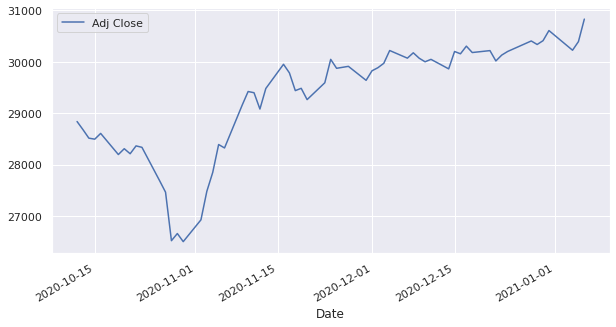

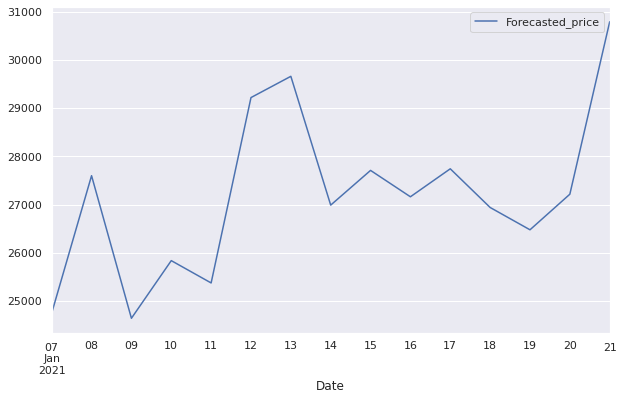

In [ ]:
df[['Adj Close']].tail(60).plot(figsize = (10,5), grid = True)
prediction.plot()

In [ ]:
fig = go.Figure()
n = prediction.index[0]
fig.add_trace(go.Scatter(x = df.index[-100:], y = df['Adj Close'][-100:],
                         marker = dict(color ="red"), name = "Actual close price"))
fig.add_trace(go.Scatter(x = prediction.index, y = prediction['Forecasted_price'], marker=dict(
        color = "green"), name = "Future prediction"))


fig.update_xaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_yaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_layout(
    title= "15 days days DJIA Forecast", 
    yaxis_title = 'DJIA (US$)',
    hovermode = "x",
    hoverdistance = 100, # Distance to show hover label of data point
    spikedistance = 1000,
    shapes = [dict(
        x0 = n, x1 = n, y0 = 0, y1 = 1, xref = 'x', yref = 'paper',
        line_width = 2)],
    annotations = [dict(x = n, y = 0.05, xref = 'x', yref = 'paper', showarrow = False, 
                        xanchor = 'left', text = 'Prediction')]) 
fig.update_layout(autosize = False, width = 1000, height = 400,)
fig.show()

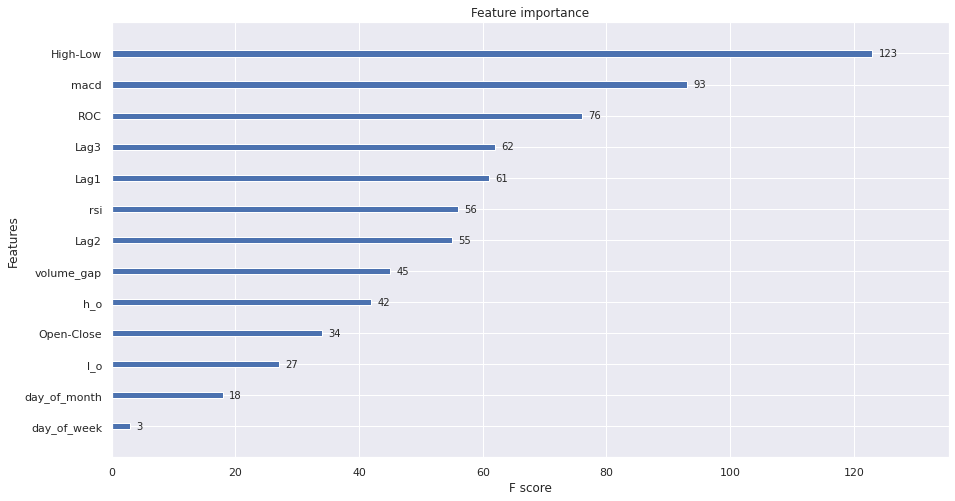

In [ ]:
from xgboost import plot_importance
# Feature importance
plt.rcParams['figure.figsize'] = [15, 8]
plot_importance(reg)


In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train, y_train)
confidence = linreg.score(X_test, y_test)
print("Confidence %:", round(confidence*100, 2))
print('\n')

print('\n')
prediction = linreg.predict(X_fcast)
print('\033[4mExpected Close price for next 30 days\033[0m')
print(prediction)
print('\n')

RMSE = np.sqrt(mean_squared_error(y_test[:future_pred], prediction[:future_pred]))
print('Test RMSE: %.3f' % RMSE)

Confidence %: 22.86




Expected Close price for next 30 days
[24863.06987059 26689.79823552 23081.24961628 22422.80833009
 23161.82379052 23039.00861219 23121.71203562 21734.99330213
 22160.61944545 21391.45190571 22798.33241306 23351.67977745
 19364.73850499 20457.83074182 25058.21090322]


Test RMSE: 10293.939


In [ ]:
!pip install python_wtd
from python_wtd import WTD
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
import warnings
import seaborn as sns
sns.set()
import pandas_datareader as web
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

df = web.DataReader('^DJI', data_source = 'yahoo', start = '2000-01-01')
print(df.head())
print('\n')
print(df.shape)

dataset = df.copy()
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=dataset.index,
                open=dataset['Open'],
                high=dataset['High'],
                low=dataset['Low'],
                close=dataset['Close'])])
fig.show()
print('\n')

# empirical quantile of daily returns
import scipy.stats
dataset['daily_return'] = dataset['Adj Close'].pct_change()
round(dataset["daily_return"],2).quantile(0.05)

import seaborn as sns
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(dataset['daily_return'], color="green")
plt.title('Dow Jones')
plt.grid(True)
plt.show()

dataset['daily_return'].plot(figsize = (10,5), grid=True)
plt.title('Daily return plot')
plt.show()

dataset['volatility'] = dataset['daily_return'].rolling(252).std()*(252**0.5)
dataset['volatility'].plot(figsize = (10,5), grid=True)
plt.title('Volatility plot')
plt.show()

# resetting index 
dataset.reset_index(inplace = True) 
dataset.tail()

dataset = dataset.sort_values(by = 'Date', ascending=True)
dataset.tail()

print(dataset.loc[[(len(dataset) -252)]]) # closing price 252 days back

plt.rcParams["figure.figsize"] = (10,6)
days = 252
start_price = 28745.089844 # Taken from above

#delta t
dt = 1/252
mu = dataset['daily_return'].mean() # mean return
sigma = dataset['daily_return'].std()  # volatility

#Function takes in stock price, number of days to run, mean and standard deviation values
def stock_monte_carlo(start_price, days, mu, sigma):
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        #Shock and drift formulas taken from the Monte Carlo formula
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        drift[x] = mu * dt
        
        #New price = Old price + Old price*(shock+drift)
        price[x] = price[x-1] + (price[x-1] * (drift[x]+shock[x]))
    return price
    
plt.plot(stock_monte_carlo(start_price, days, mu, sigma))
plt.xlabel('Days')
plt.ylabel('Price (US$)')
plt.title('Monte-Carlo Analysis for Dow Jones')
plt.show()

runs = 10000
simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

plt.hist(simulations, bins = 200)

plt.figtext(0.6,0.8,s="Start price: $%.2f" %start_price)
plt.figtext(0.6,0.7,"Mean final price: $%.2f" % simulations.mean())
plt.figtext(0.6,0.6,"VaR(0.99): $%.2f" % (start_price -q,))
plt.figtext(0.15,0.6, "q(0.99): $%.2f" % q)
plt.axvline(x=q, linewidth=4, color='r')

plt.title(u"Final price distribution for Dow Jones after %s days" %days, weight='bold')
plt.show()

#dataset.set_index('Date', inplace=True)
dq = df.copy()
dq['h_o'] = dq['High'] - dq['Open'] # distance between Highest and Opening price
dq['l_o'] = dq['Low'] - dq['Open']
dq['Open-Close'] = dq.Open - dq.Close
dq['High-Low'] = dq.High - dq.Low 
dq['volume_gap'] = dq.Volume.pct_change()
# feature engineering
dq['day_of_week'] = dq.index.dayofweek
dq['day_of_month'] = dq.index.day

ema_12 = dq['Adj Close'].ewm(span=10).mean()
ema_26 = dq['Adj Close'].ewm(span=26).mean()
dq['ROC'] = ((dq['Adj Close'] - dq['Adj Close'].shift(5)) / (dq['Adj Close'].shift(5)))*100

delta = dq['Adj Close'].diff()
window = 14
up_days = delta.copy()
up_days[delta<=0]=0.0
down_days = abs(delta.copy())
down_days[delta>0]=0.0
RS_up = up_days.rolling(window).mean()
RS_down = down_days.rolling(window).mean()
dq['rsi'] = 100-100/(1+RS_up/RS_down)
dq['macd'] = ema_12 - ema_26
#print(dataset)

lags = 3
# Create the shifted lag series of prior trading period close values
for i in range(0, lags):
    dq["Lag%s" % str(i+1)] = dq["Adj Close"].shift(i+1).pct_change()

future_pred = int(15)
dq['prediction'] = dq['Adj Close'].shift(-future_pred)
dq.head()

dq = dq.drop(['High','Low','Open','Close','Volume',	'Adj Close'],1)

dq.dropna(inplace=True)
X = dq.drop(['prediction'],1)
y = dq.prediction
X_fcast = X[-future_pred:] # future prediction set
X = X[:-future_pred] # removing last 15 rows
y = y[:-future_pred]
#y = dq.prediction

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score
# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_train, ols.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_train, ols.predict(X_train)))
# The mean squared error
print("Mean squared error: %.2f"
% mean_squared_error(y_test, ols.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, ols.predict(X_test)))

print('Training Variance score (R^2)', r2_score(y_train, ols.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Test Variance score (R^2): ', r2_score(y_test, ols.predict(X_test)))

reg = XGBRegressor(objective ='reg:squarederror', n_jobs=-1).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_train, reg.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, reg.predict(X_test)))

prediction = reg.predict(X_fcast)
print('\033[4mExpected Close price for next 15 days\033[0m')
print(prediction)
print('\n')

rmse = np.sqrt(mean_squared_error(y_test[:future_pred], prediction[:future_pred]))
print('Test RMSE: %.3f' % rmse)

d = df[['Adj Close']].tail(len(prediction)); 
d.reset_index(inplace = True)
d = d.append(pd.DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], 
                                             periods = (len(d)+1), freq = 'D', closed = 'right')}))
d = d.tail(future_pred); 
d.set_index('Date', inplace = True)
prediction = pd.DataFrame(prediction)
prediction.index = d.index
prediction.rename(columns = {0: 'Forecasted_price'}, inplace=True)
print(prediction)

fig = go.Figure()
n = prediction.index[0]
fig.add_trace(go.Scatter(x = df.index[-100:], y = df['Adj Close'][-100:],
                         marker = dict(color ="red"), name = "Actual close price"))
fig.add_trace(go.Scatter(x = prediction.index, y = prediction['Forecasted_price'], marker=dict(
        color = "green"), name = "Future prediction"))


fig.update_xaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_yaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
fig.update_layout(
    title= "15 days days DJIA Forecast", 
    yaxis_title = 'DJIA (US$)',
    hovermode = "x",
    hoverdistance = 100, # Distance to show hover label of data point
    spikedistance = 1000,
    shapes = [dict(
        x0 = n, x1 = n, y0 = 0, y1 = 1, xref = 'x', yref = 'paper',
        line_width = 2)],
    annotations = [dict(x = n, y = 0.05, xref = 'x', yref = 'paper', showarrow = False, 
                        xanchor = 'left', text = 'Prediction')]) 
fig.update_layout(autosize = False, width = 1000, height = 400,)
fig.show()

from xgboost import plot_importance
# Feature importance
plt.rcParams['figure.figsize'] = [15, 8]
plot_importance(reg)


from sklearn.linear_model import LinearRegression

linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train, y_train)
confidence = linreg.score(X_test, y_test)
print("Confidence %:", round(confidence*100, 2))
print('\n')

print('\n')
prediction = linreg.predict(X_fcast)
print('\033[4mExpected Close price for next 30 days\033[0m')
print(prediction)
print('\n')

RMSE = np.sqrt(mean_squared_error(y_test[:future_pred], prediction[:future_pred]))
print('Test RMSE: %.3f' % RMSE)
